# Statistical analysis - experiment 1 

### Import the libraries 

In [1]:
import os
import numpy as np
import pandas as pd
from csv import reader
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline 

### Function to collect all csv-files in the folder

In [2]:
def list_csv_files(resultsdir):
    csv_files = []

    if os.path.isdir(resultsdir):
        for root, dirs, files in list(os.walk(resultsdir)):
            for name in files:
                subdir = root.split(resultsdir)
                all('' == s for s in subdir)
                
                if subdir[1].startswith('/'):
                    subdirname = subdir[1][1:]
                else:
                    subdirname = subdir[1]

                if name.lower().endswith('.csv'):
                    if all('' == s for s in subdir):
                        csv_files.append(name)
                    else:
                        csv_files.append(os.path.join(subdirname, name))
    
        csv_files.sort()

    return csv_files

### Function to get all unique combinations

In [3]:
def get_unique_combinations(csv_files):
    unique_combinations = []
    for c in range(len(csv_files)):
        csv_file = csv_files[c]
        splits = csv_file.split("/")
        run_no = splits[0].split("run")[-1]
        sam_mt = splits[1].split("_")[0]
        unc_mt = splits[1].split("_")[1]
        prob = splits[1].split("_")[2]
        fwp = splits[1].split("_")[3]
        sam_sz = splits[1].split("_")[4]
        
        if unc_mt == 'mean':
            unc_mt = 'average'
        
        unique_combination = sam_mt + '_' + unc_mt + '_' + prob + '_' + fwp + '_' + sam_sz
        unique_combinations.append(unique_combination)
    return list(set(unique_combinations))

### Load the csv-files and store the data in a pandas-dataframe 

In [4]:
resultsdir = "results/exp1"
two_up = os.path.abspath(os.path.join(os.getcwd(),"../.."))
resultsdir = os.path.join(two_up, resultsdir)
csv_files = list_csv_files(resultsdir)

clmns = ["sampling_method", "certainty_method", "dropout_probability", "number_forward_passes", "sampling_size", "unique_combination", "run", "number_images", "mAP"]
df = pd.DataFrame(columns=clmns)
unique_combinations = get_unique_combinations(csv_files)
ucs = [None] * len(unique_combinations)

for c in range(len(csv_files)):
    csv_file = csv_files[c]
    splits = csv_file.split("/")
    run_no = splits[0].split("run")[-1]
    sam_mt = splits[1].split("_")[0]
    unc_mt = splits[1].split("_")[1]
    prob = splits[1].split("_")[2]
    fwp = splits[1].split("_")[3]
    sam_sz = splits[1].split("_")[4]
    
    if unc_mt == 'mean':
        unc_mt = 'average'
        
    unique_combination = sam_mt + '_' + unc_mt + '_' + prob + '_' + fwp + '_' + sam_sz
    uc_id = unique_combinations.index(unique_combination) 
    ucs[uc_id] = unique_combination

    with open(os.path.join(resultsdir, csv_file), 'r') as read_obj:
        csv_reader = reader(read_obj)
        next(csv_reader)
        for row in csv_reader:
            data = [sam_mt, unc_mt, float(prob), int(fwp), int(sam_sz), int(uc_id), int(run_no), int(row[0]), float(row[1])]
            df.loc[len(df)] = data
            
df

,sampling_method,certainty_method,dropout_probability,number_forward_passes,sampling_size,unique_combination,run,number_images,mAP
0,uncertainty,average,0.25,20,200,5,1,100,19.5
1,uncertainty,average,0.25,20,200,5,1,300,34.3
2,uncertainty,average,0.25,20,200,5,1,500,41.4
3,uncertainty,average,0.25,20,200,5,1,700,46.5
4,uncertainty,average,0.25,20,200,5,1,900,45.4
...,...,...,...,...,...,...,...,...,...
775,uncertainty,min,0.75,40,200,4,5,1700,51.7
776,uncertainty,min,0.75,40,200,4,5,1900,52.9
777,uncertainty,min,0.75,40,200,4,5,2100,52.9
778,uncertainty,min,0.75,40,200,4,5,2300,57.9


### Plot the performance for each of the combinations

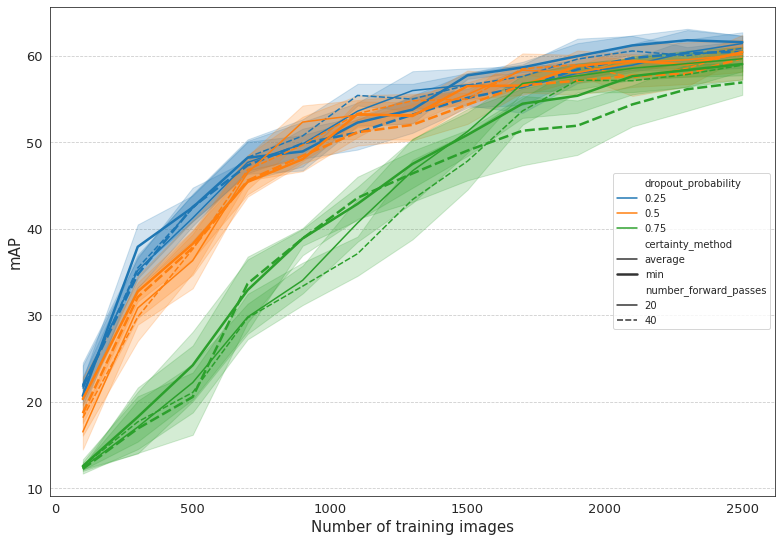

In [5]:
font_size = 15
digit_size = 13
annot_size = 14

sns.set_style("whitegrid")
sns.set_style("white")
f, ax = plt.subplots(figsize=(13, 9))

ax = sns.lineplot(x="number_images", y="mAP", style="number_forward_passes", hue="dropout_probability", size="certainty_method", sizes=[1.5, 2.5], ci=95, data=df, palette = "tab10")
ax.grid(which='major', axis='y', linestyle='--')
ax.tick_params(labelrotation=0, labelsize=digit_size)

plt.xlabel('Number of training images', fontsize=font_size)
plt.ylabel('mAP', fontsize=font_size)
plt.legend(loc='center right')
plt.savefig('/mnt/nvme2n1p2/PieterBlok/PhD/Paper 04 - Active Learning/Results/exp1/exp1.png')
plt.show()

### ANOVA with repeated measures 

In [6]:
num_img = df["number_images"].values.ravel()
num_img = pd.unique(num_img)

for ni in range(len(num_img)):
    cur_num_img = num_img[ni]
    sel = df[df["number_images"] == cur_num_img]
    print(cur_num_img)
    mean = sel.groupby(['dropout_probability', 'number_forward_passes', 'certainty_method']).mean()
    
    aovrm = AnovaRM(data=sel, depvar='mAP', subject='run', within=['dropout_probability', 'number_forward_passes', 'certainty_method'], aggregate_func='mean')
    res = aovrm.fit()
    print(res)

100
                                         Anova
                                                           F Value Num DF Den DF Pr > F
---------------------------------------------------------------------------------------
dropout_probability                                        61.0542 2.0000 8.0000 0.0000
number_forward_passes                                       0.1067 1.0000 4.0000 0.7603
certainty_method                                            1.2789 1.0000 4.0000 0.3213
dropout_probability:number_forward_passes                   0.5259 2.0000 8.0000 0.6101
dropout_probability:certainty_method                        2.5153 2.0000 8.0000 0.1421
number_forward_passes:certainty_method                      1.6959 1.0000 4.0000 0.2627
dropout_probability:number_forward_passes:certainty_method  4.1777 2.0000 8.0000 0.0572

300
                                         Anova
                                                           F Value  Num DF Den DF Pr > F
----------------

                                         Anova
                                                           F Value Num DF Den DF Pr > F
---------------------------------------------------------------------------------------
dropout_probability                                        17.0773 2.0000 8.0000 0.0013
number_forward_passes                                       7.3451 1.0000 4.0000 0.0535
certainty_method                                            5.0755 1.0000 4.0000 0.0874
dropout_probability:number_forward_passes                   1.8234 2.0000 8.0000 0.2226
dropout_probability:certainty_method                        2.3721 2.0000 8.0000 0.1553
number_forward_passes:certainty_method                      1.0068 1.0000 4.0000 0.3724
dropout_probability:number_forward_passes:certainty_method  0.7319 2.0000 8.0000 0.5106

1900
                                         Anova
                                                           F Value Num DF Den DF Pr > F
--------------------

In [7]:
## three-way ANOVA on the dropout_probability, the number_forward_passes and the certainty_method with repeated measures on the runs
mean = df.groupby(['dropout_probability', 'number_forward_passes', 'certainty_method']).mean()
var = df.groupby(['dropout_probability', 'number_forward_passes', 'certainty_method']).var()
mean1 = df.groupby(['dropout_probability']).mean()
mean2 = df.groupby(['number_forward_passes']).mean().drop(columns=['dropout_probability'])
mean3 = df.groupby(['certainty_method']).mean().drop(columns=['dropout_probability'])
aovrm = AnovaRM(data=df, depvar='mAP', subject='run', within=['dropout_probability', 'number_forward_passes', 'certainty_method'], aggregate_func='mean')

res = aovrm.fit()
print(mean)
print(mean1)
print(mean2)
print(mean3)
print(res)

                                                                  mAP
dropout_probability number_forward_passes certainty_method           
0.25                20                    average           50.535385
                                          min               51.152308
                    40                    average           51.063077
                                          min               50.052308
0.50                20                    average           49.187692
                                          min               49.350769
                    40                    average           49.150769
                                          min               48.380000
0.75                20                    average           41.975385
                                          min               42.513846
                    40                    average           40.546154
                                          min               40.900000
                    

In [8]:
do_25_50 = df[(df["dropout_probability"] == 0.25) | (df["dropout_probability"] == 0.50)]

## two-way ANOVA on the number_forward_passes and the uncertainty_method with repeated measures on the runs
mean = do_25_50.groupby(['number_forward_passes', 'certainty_method']).mean().drop(columns=['dropout_probability'])
var = do_25_50.groupby(['number_forward_passes', 'certainty_method']).var().drop(columns=['dropout_probability'])
aovrm = AnovaRM(data=do_25_50, depvar='mAP', subject='run', within=['number_forward_passes', 'certainty_method'], aggregate_func='mean')

res = aovrm.fit()
print(mean)
print(var)
print(res)

                                              mAP
number_forward_passes certainty_method           
20                    average           49.861538
                      min               50.251538
40                    average           50.106923
                      min               49.216154
                                               mAP
number_forward_passes certainty_method            
20                    average           150.905796
                      min               139.274765
40                    average           147.597394
                      min               134.493613
                               Anova
                                       F Value Num DF Den DF Pr > F
-------------------------------------------------------------------
number_forward_passes                   1.8594 1.0000 4.0000 0.2444
certainty_method                        0.6006 1.0000 4.0000 0.4816
number_forward_passes:certainty_method  4.1711 1.0000 4.0000 0.1107



In [9]:
do_25 = df[df["dropout_probability"] == 0.25]

## two-way ANOVA on the number_forward_passes and the uncertainty_method with repeated measures on the runs
mean = do_25.groupby(['number_forward_passes', 'certainty_method']).mean().drop(columns=['dropout_probability'])
var = do_25.groupby(['number_forward_passes', 'certainty_method']).var().drop(columns=['dropout_probability'])
aovrm = AnovaRM(data=do_25, depvar='mAP', subject='run', within=['number_forward_passes', 'certainty_method'], aggregate_func='mean')

res = aovrm.fit()
print(mean)
print(var)
print(res)

                                              mAP
number_forward_passes certainty_method           
20                    average           50.535385
                      min               51.152308
40                    average           51.063077
                      min               50.052308
                                               mAP
number_forward_passes certainty_method            
20                    average           130.002947
                      min               135.934721
40                    average           131.809240
                      min               126.150659
                               Anova
                                       F Value Num DF Den DF Pr > F
-------------------------------------------------------------------
number_forward_passes                   0.7290 1.0000 4.0000 0.4413
certainty_method                        2.8084 1.0000 4.0000 0.1691
number_forward_passes:certainty_method  2.5899 1.0000 4.0000 0.1828



### Summarize the data

In [10]:
uc = df.groupby(['unique_combination', 'run']).mean().reset_index()
uc_print = uc.groupby(['unique_combination']).mean().drop(columns=['run', 'dropout_probability'])
uc_print.insert(0, "dropout_probability", [ucs[u].split("_")[2] for u in range(len(ucs))], True)
uc_print.insert(1, "certainty_method", [ucs[u].split("_")[1] for u in range(len(ucs))], True)
uc_print.insert(2, "number_forward_passes", [ucs[u].split("_")[3] for u in range(len(ucs))], True)
ucf = uc_print.sort_values(by='mAP', ascending=False)
ucf

,dropout_probability,certainty_method,number_forward_passes,mAP
unique_combination,,,,
9,0.25,min,20,51.152308
7,0.25,average,40,51.063077
5,0.25,average,20,50.535385
11,0.25,min,40,50.052308
3,0.50,min,20,49.350769
1,0.50,average,20,49.187692
2,0.50,average,40,49.150769
10,0.50,min,40,48.380000
6,0.75,min,20,42.513846


### ANOVA table and LSD calculation

In [11]:
# https://www.statsmodels.org/devel/examples/notebooks/generated/interactions_anova.html#Two-way-ANOVA
# https://www.statology.org/fishers-least-significant-difference/
# https://personal.utdallas.edu/~herve/abdi-LSD2010-pretty.pdf
# https://stackoverflow.com/questions/19339305/python-function-to-get-the-t-statistic
# https://www.youtube.com/watch?v=ZRX4lFtMboo

from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm

nosum_lm = ols("mAP ~ C(unique_combination)", data=uc).fit()
an = anova_lm(nosum_lm)
print(an)

runs = 5
t = stats.t.ppf(1-0.025, an.df.Residual)
LSD = t * np.sqrt(an.mean_sq.Residual * (1/runs + 1/runs))
print("Least Significant Difference: {:.2f}".format(LSD))

                         df      sum_sq    mean_sq          F        PR(>F)
C(unique_combination)  11.0  982.941021  89.358275  41.175186  1.171044e-20
Residual               48.0  104.169467   2.170197        NaN           NaN
Least Significant Difference: 1.87
